# Solving Lunar Lander problem (Continuous version)

## PPO Implementation

### Useful packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
from tqdm import trange
from collections import deque
from typing import Tuple, List, Dict

import csv
import typing
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

### Useful functions

In [3]:
# Function to compute the running average of the last N elements of a vector x
def running_average(x, N):
    ''' 
    Function used to compute the running average of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
        mean_first_N = np.mean(y[:N])
        y[:N] = mean_first_N
    else:
        y = np.zeros_like(x)
        y[:] = np.mean(x)
    return y

# pytorch-compatible density function for the 1-D distribution

def normal_pdf(x, mean, std_dev):
    factor = 1.0 / (torch.sqrt(2 * np.pi * std_dev))
    exponent = torch.exp(-((x - mean) ** 2) / (2 * std_dev))
    return factor * exponent

### Definition of our main classes (Replay buffer, Networks, etc)

In [26]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class BaseAgent:
    def __init__(self, num_actions: int):
        self.num_actions = num_actions

    def forward(self, state: np.ndarray):
        pass

    def backward(self):
        pass

class ExperienceBuffer:
    def __init__(self, max_length):
        self.buffer = deque(maxlen=max_length)

    def add_experience(self, experience: Experience):
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def sample_batch(self, batch_size):
        if batch_size > len(self.buffer):
            raise IndexError('Tried to sample too many elements from the buffer!')
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        return zip(*batch)

# Define the Actor Network
class ActorNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(ActorNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, 400)
        self.mean_layer = nn.Linear(400, 200)
        self.mean_output = nn.Linear(200, output_dim)
        self.std_dev_layer = nn.Linear(400, 200)
        self.std_dev_output = nn.Linear(200, output_dim)
        
    def forward(self, x: torch.Tensor):
        x = torch.relu(self.input_layer(x))
        mean = torch.tanh(self.mean_output(torch.relu(self.mean_layer(x))))
        std_dev = torch.sigmoid(self.std_dev_output(torch.relu(self.std_dev_layer(x))))
        return mean, std_dev
    
# Define the Critic Network
class CriticNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(CriticNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, 400)
        self.hidden_layer = nn.Linear(400, 200)
        self.output_layer = nn.Linear(200, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer(x))
        return self.output_layer(x)
    
class RandomAgent(BaseAgent):
    def __init__(self, num_actions: int):
        super(RandomAgent, self).__init__(num_actions)

    def forward(self, state: np.ndarray) -> np.ndarray:
        return np.clip(-1 + 2 * np.random.rand(self.num_actions), -1, 1)

### Launch training

In [43]:
# Hyperparameters

num_episodes = 1000
discount_factor = 0.99
learning_rate_critic = 1e-3
learning_rate_actor = 1e-5
epsilon = 0.2

In [42]:
def train_lunar_lander(num_episodes: int = 1000, 
                       discount_factor: float = 0.99,
                       learning_rate_critic : float = 1e-3, learning_rate_actor : float = 1e-5, epsilon=0.2):
    """
    Train a PPO algorithm in the Lunar Lander environment.
    
    Args:
        env_name (str, optional): Name of the gym environment. Defaults to 'LunarLander-v2'.
        n_episodes (int, optional): Number of training episodes. Defaults to 620.
        discount_factor (float, optional): Discount factor for future rewards. Defaults to 1.0.
        learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.
    
    Returns:
        Tuple containing episode rewards and number of steps per episode.
    """

    env = gym.make('LunarLanderContinuous-v3')
    state, _ = env.reset()

    # Hyerparameters

    running_avg_window = 50
    num_actions = len(env.action_space.high)
    state_dim = len(env.observation_space.high)
    num_updates = 10
    buffer_size = 10000

    # Initialize reward and step lists
    episode_rewards = []
    episode_steps = []

    # Fill up Buffer with Random experiences
    agent = RandomAgent(num_actions)

    # Create networks
    actor = ActorNetwork(input_dim=state_dim, output_dim=num_actions)
    critic = CriticNetwork(input_dim=state_dim, output_dim=1)

    optimizer_actor = optim.Adam(actor.parameters(), lr=learning_rate_actor)
    optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)

    # Training Loop
    progress_bar = trange(num_episodes, desc="Episode: ", leave=True)
    for episode in progress_bar:

        buffer = ExperienceBuffer(max_length=buffer_size)
        total_reward = 0
        state, _ = env.reset()
        done = False
        time_step = 0

        rewards = []
        states = []
        actions = []

        while not done:
            # env.render() # Render the environment

            with torch.no_grad():
                states.append(state)
                mean, std_dev = actor(torch.tensor(np.array([state]), dtype=torch.float32))
                mean = mean.detach().numpy()
                std_dev = torch.sqrt(std_dev).detach().numpy()
                action = np.clip(np.random.normal(mean, std_dev), -1, 1).flatten()
                actions.append(action)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            rewards.append(reward)

            if len(rewards) > 1:
                for i in range(len(rewards)-1):
                    rewards[i] += (discount_factor ** (time_step - i)) * reward

            total_reward += reward

            exp = Experience(state, action, reward, next_state, done)
            buffer.add_experience(exp)

            # Update state for next iteration
            state = next_state
            time_step += 1

        # Compute advantage and old_pi and Psi as targets for training

        rewards = torch.tensor(rewards, requires_grad=False, dtype=torch.float32)
        states = torch.tensor(np.array(states), requires_grad=True, dtype=torch.float32)
        actions = torch.tensor(np.array(actions), requires_grad=False, dtype=torch.float32)

        values = critic(states)
        values = torch.reshape(values, rewards.shape)
        advantages = rewards - values.detach()

        means, std_devs = actor(states)
        pdf1 = normal_pdf(actions[:, 0], means[:, 0], std_devs[:, 0])
        pdf2 = normal_pdf(actions[:, 1], means[:, 1], std_devs[:, 1])
        pi = pdf1 * pdf2
        old_pi = pi.detach()

        for iter in range(num_updates):
            # Optimize Critic
            critic.train()
            values = critic(states)
            values = torch.reshape(values, rewards.shape)
            means, std_devs = actor(states)
            pdf1 = normal_pdf(actions[:, 0], means[:, 0], std_devs[:, 0])
            pdf2 = normal_pdf(actions[:, 1], means[:, 1], std_devs[:, 1])
            pi = pdf1 * pdf2
            loss_critic = nn.functional.mse_loss(values, rewards.detach())
            optimizer_critic.zero_grad()
            loss_critic.backward()
            nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.)
            optimizer_critic.step()

            # Optimize Actor
            ratio = torch.div(pi, old_pi)
            clipped_ratio = torch.max(
                torch.min(
                    ratio, 
                    torch.tensor(1 + epsilon, requires_grad=False, dtype=torch.float32)), 
                torch.tensor(1 - epsilon, requires_grad=False, dtype=torch.float32)
                )

            advantages = advantages.detach()
            actor.train()
            loss_actor = -torch.mean(torch.min(ratio * advantages, clipped_ratio * advantages))
            optimizer_actor.zero_grad()
            loss_actor.backward()
            nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.)
            optimizer_actor.step()

        # Add rewards and number of steps
        episode_rewards.append(total_reward)
        episode_steps.append(time_step)
        progress_bar.set_description("Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            episode, 
            total_reward, 
            time_step, 
            running_average(episode_rewards, running_avg_window)[-1],
            running_average(episode_steps, running_avg_window)[-1]
            )
        )
    # torch.save(actor.state_dict(), 'models/ppo_model.pth')
    env.close()
    return episode_rewards, episode_steps

In [ ]:
episode_rewards, episode_steps = train_lunar_lander(num_episodes, discount_factor, learning_rate_critic, learning_rate_actor, epsilon)

Episode 999 - Reward/Steps: 9.3/130 - Avg. Reward/Steps: 154.8/282: 100%|██████████| 1000/1000 [10:15<00:00,  1.62it/s]


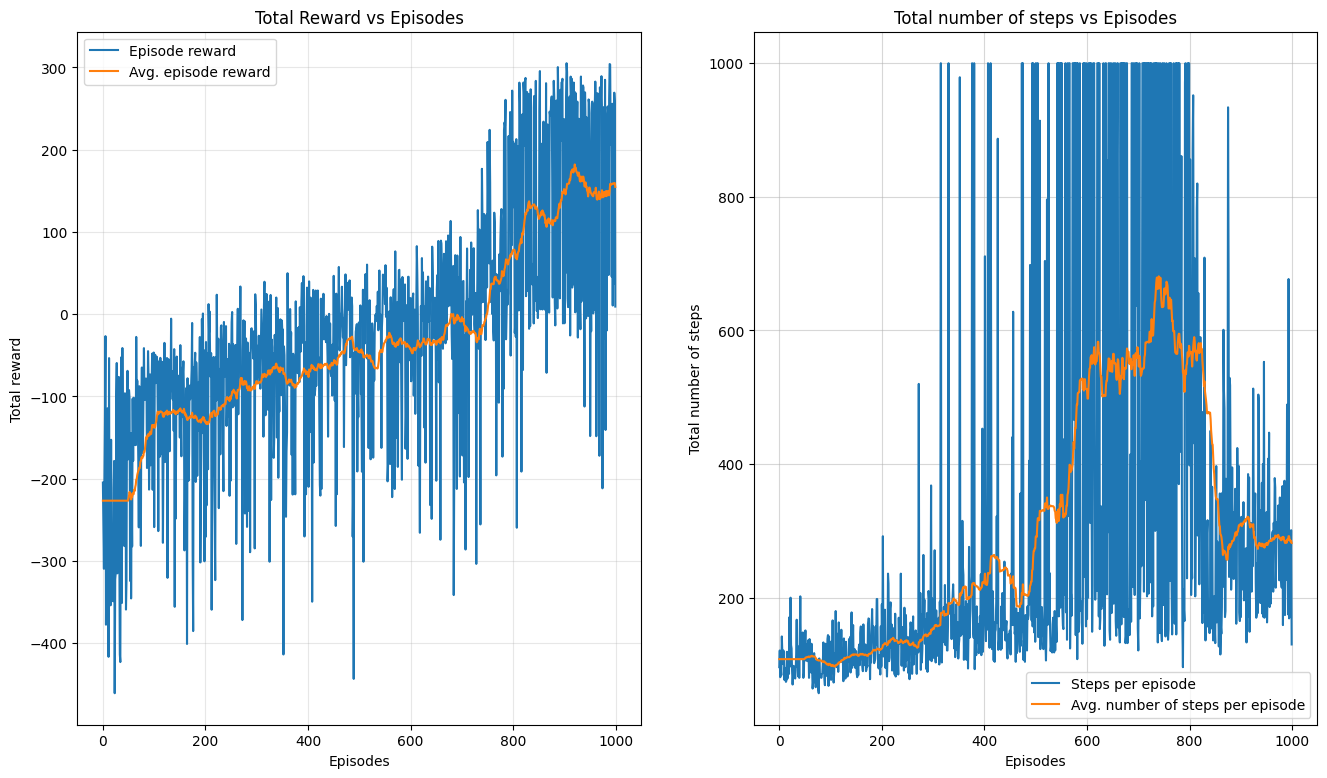

In [73]:
# Plot Rewards and steps
running_avg_window = 50
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

ax[0].plot(range(num_episodes), episode_rewards, label='Episode reward')
ax[0].plot(range(num_episodes), running_average(
    episode_rewards, running_avg_window), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(range(num_episodes), episode_steps, label='Steps per episode')
ax[1].plot(range(num_episodes), running_average(
    episode_steps, running_avg_window), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig('figures/output_ppo.png', dpi=300)
plt.show()

### Comparing hyperparameters

In [53]:
def plot_multiple_training_results(training_results: List[Tuple[List[float], List[int], float]], 
                                    n_ep_running_average: int = 30,
                                    hyperparameter_name='discount factor') -> None:
    """
    Plot training results for multiple runs with different discount factors.
    
    Args:
        training_results (List[Tuple[List[float], List[int], float]]): 
            A list of tuples containing (episode_rewards, episode_steps, discount_factor)
        n_ep_running_average (int, optional): Window size for running average. Defaults to 50.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

    # Color palette for different runs
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    # Reward plot
    for (episode_rewards, _, discount_factor), color in zip(training_results, colors):
        avg_rewards = running_average(episode_rewards, n_ep_running_average)
        ax1.plot(range(len(episode_rewards)), 
                 avg_rewards, label=f'Avg. {hyperparameter_name} = {discount_factor}', color=color, linestyle='--')
    
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Total reward')
    ax1.set_title('Total Reward vs Episodes')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Steps plot
    for (_, episode_steps, discount_factor), color in zip(training_results, colors):
        avg_steps = running_average(episode_steps, n_ep_running_average)
        ax2.plot(range(len(episode_steps)), 
                 avg_steps, label=f'Avg. {hyperparameter_name} = {discount_factor}', color=color, linestyle='--')
    
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Total number of steps')
    ax2.set_title('Total number of steps vs Episodes')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def compareDiscountFactors():
    """
    compareDiscountFactors function to compare Lunar Lander agent training with different discount factors.
    """
    try:
        # List of discount factors to compare
        discount_factors = [0.5, 0.9, 0.99, 0.999]
        
        # Train multiple models with different discount factors
        training_results = []
        for gamma in discount_factors:
            print(f"Training with discount factor γ = {gamma}")
            episode_rewards, episode_steps = train_lunar_lander(
                discount_factor=gamma, 
                num_episodes=1000  # Reduced for faster comparison
            )
            training_results.append((episode_rewards, episode_steps, gamma))

    except Exception as e:
        print(f"An error occurred during training: {e}")
    return training_results

def compareEpsilons():
    """
    compareDiscountFactors function to compare Lunar Lander agent training with different discount factors.
    """
    try:
        # List of discount factors to compare
        epsilons = [0.001, 0.01, 0.1, 1]
        
        # Train multiple models with different discount factors
        training_results = []
        for eps in epsilons:
            print(f"Training with epsilon = {eps}")
            episode_rewards, episode_steps = train_lunar_lander(
                discount_factor=0.99, 
                num_episodes=1000,
                epsilon=eps
            )
            training_results.append((episode_rewards, episode_steps, eps))

    except Exception as e:
        print(f"An error occurred during training: {e}")
    return training_results


Training with discount factor γ = 0.5


Episode 999 - Reward/Steps: -243.2/194 - Avg. Reward/Steps: -173.4/228: 100%|██████████| 1000/1000 [08:16<00:00,  2.02it/s]


Training with discount factor γ = 0.9


Episode 999 - Reward/Steps: -86.8/1000 - Avg. Reward/Steps: -88.9/1000: 100%|██████████| 1000/1000 [19:14<00:00,  1.15s/it]


Training with discount factor γ = 0.99


Episode 999 - Reward/Steps: 16.4/226 - Avg. Reward/Steps: 122.6/477: 100%|██████████| 1000/1000 [13:36<00:00,  1.22it/s]


Training with discount factor γ = 0.999


Episode 999 - Reward/Steps: 50.9/141 - Avg. Reward/Steps: -101.2/223: 100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


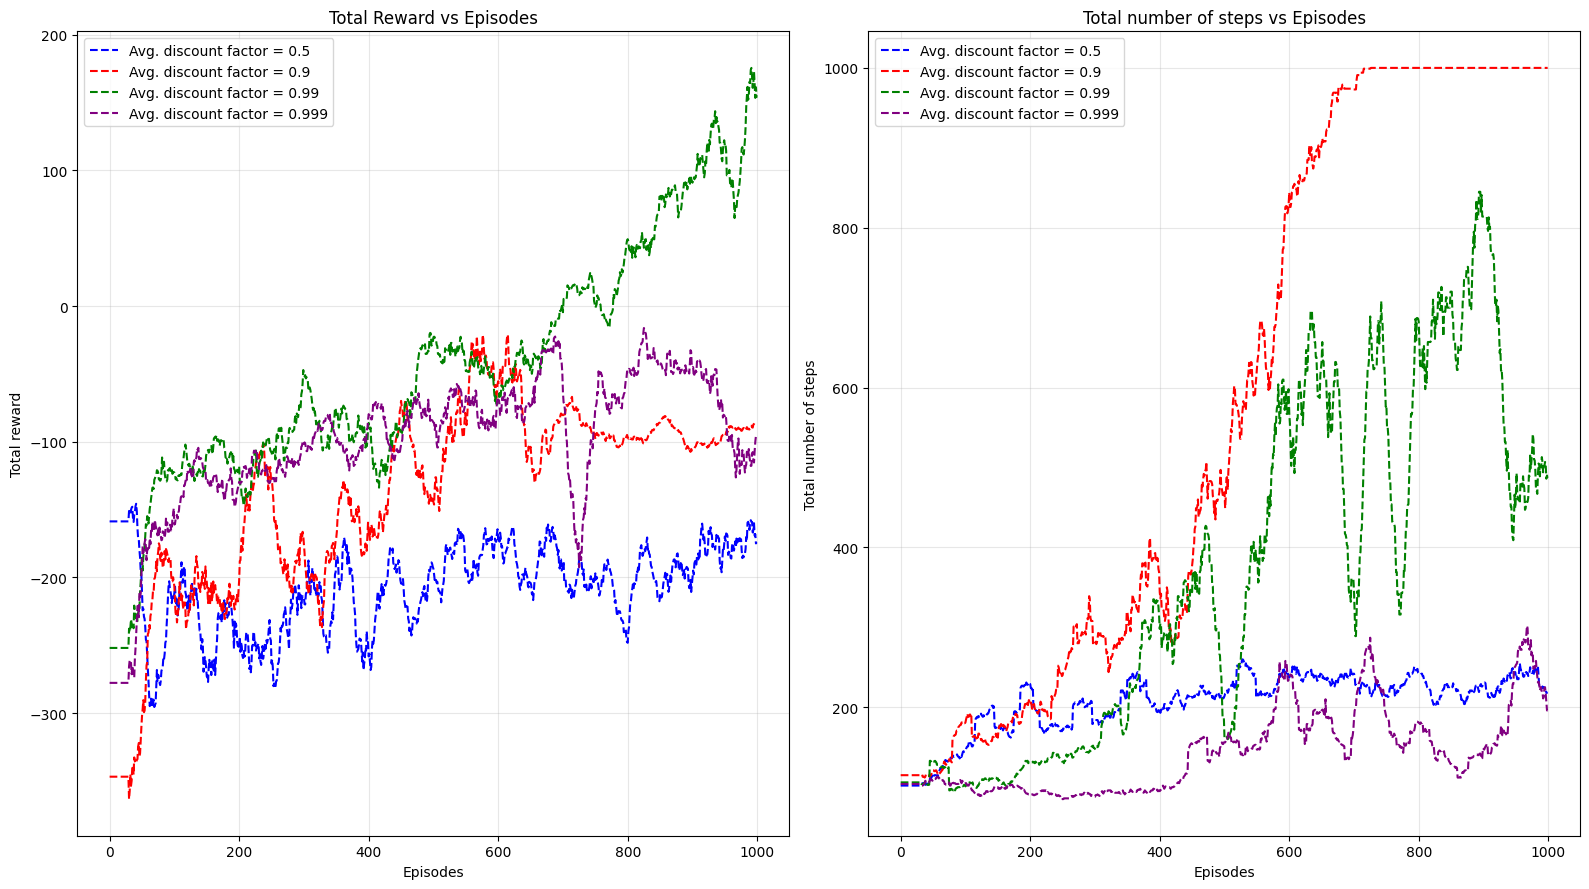

In [54]:
# compare discount factors
training_results = compareDiscountFactors()
plot_multiple_training_results(training_results, 30, 'discount factor') 

Training with epsilon = 0.001


Episode 999 - Reward/Steps: -233.0/133 - Avg. Reward/Steps: -130.0/117: 100%|██████████| 1000/1000 [05:05<00:00,  3.28it/s]


Training with epsilon = 0.01


Episode 999 - Reward/Steps: -90.0/309 - Avg. Reward/Steps: -61.6/433: 100%|██████████| 1000/1000 [07:34<00:00,  2.20it/s]


Training with epsilon = 0.1


Episode 999 - Reward/Steps: 264.1/267 - Avg. Reward/Steps: 143.1/223: 100%|██████████| 1000/1000 [09:28<00:00,  1.76it/s]


Training with epsilon = 1


Episode 999 - Reward/Steps: 262.3/291 - Avg. Reward/Steps: 159.9/269: 100%|██████████| 1000/1000 [13:41<00:00,  1.22it/s]


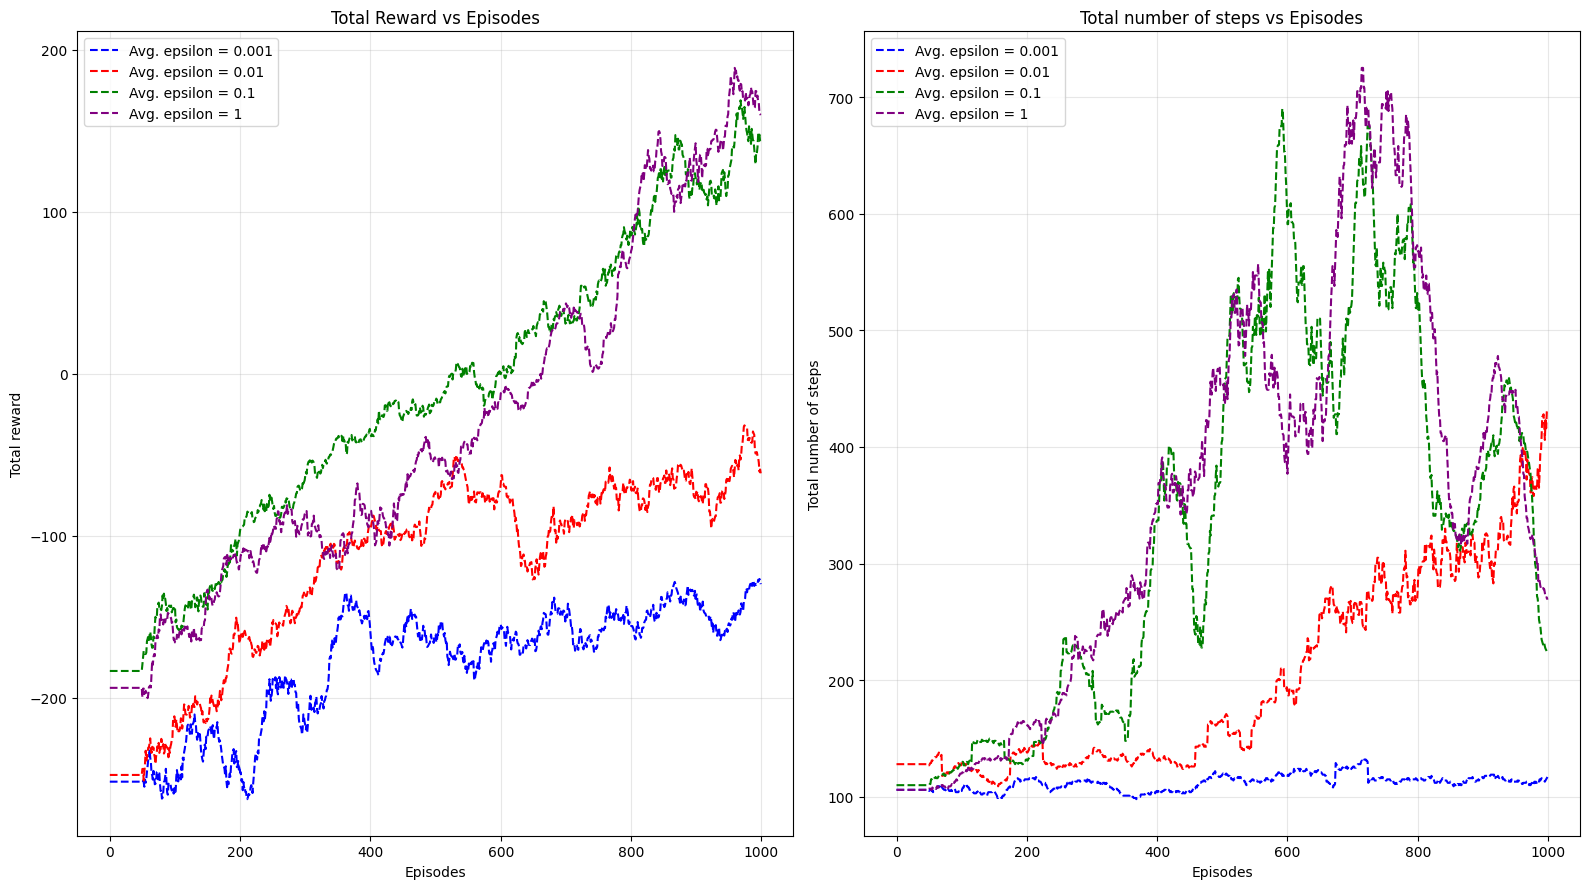

In [ ]:
# compare epsilons 
training_results = compareEpsilons()
plot_multiple_training_results(training_results, 50, 'epsilon') 

### Checking Solution

Here we check the validity of our model. We achieve high performances with the above parameters (200+ average reward over 50 episodes)

In [12]:
env = gym.make('LunarLanderContinuous-v3')
state, _ = env.reset()

num_actions = len(env.action_space.high)
state_dim = len(env.observation_space.high)

actor = ActorNetwork(input_dim=state_dim, output_dim=num_actions)
actor.load_state_dict(torch.load('models/ppo_model.pth'))
print('Network model: {}'.format(actor))

# Parameters
num_episodes = 50
confidence_threshold = 125

# Reward
episode_rewards = [] # Used to store episodes reward

# Simulate episodes
print('Checking solution...')

progress_bar = trange(num_episodes, desc='Episode: ', leave=True)
for i in trange(num_episodes, desc='Episode: ', leave=True):
    progress_bar.set_description("Episode {}".format(i))
    
    done = False
    state, _ = env.reset()
    total_reward = 0.0
    
    while not done:
        mean, std_dev = actor(torch.tensor(np.array([state]), dtype=torch.float32))
        mean = mean.detach().numpy()
        std_dev = torch.sqrt(std_dev).detach().numpy()

        action = np.clip(np.random.normal(mean, std_dev), -1, 1).flatten()  
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        state = next_state

    episode_rewards.append(total_reward)
    env.close()

avg_reward = np.mean(episode_rewards)
confidence = np.std(episode_rewards) * 1.96 / np.sqrt(num_episodes)

print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(avg_reward, confidence))

if avg_reward - confidence > confidence_threshold or avg_reward + confidence > confidence_threshold:
    print('Your policy passed the test!')
else:
    print("Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence".format(confidence_threshold))

C:\Users\cyrie\AppData\Local\Temp\ipykernel_181232\621841202.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load('models/ppo_model.pth'))


Network model: ActorNetwork(
  (input_layer): Linear(in_features=8, out_features=400, bias=True)
  (mean_layer): Linear(in_features=400, out_features=200, bias=True)
  (mean_output): Linear(in_features=200, out_features=2, bias=True)
  (std_dev_layer): Linear(in_features=400, out_features=200, bias=True)
  (std_dev_output): Linear(in_features=200, out_features=2, bias=True)
)
Checking solution...


Episode: 100%|██████████| 50/50 [00:12<00:00,  4.14it/s]

Policy achieves an average total reward of 211.8 +/- 26.3 with confidence 95%.
Your policy passed the test!


# Hyperparameter Optimizer

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define the search space for hyperparameters
search_space = [
    Real(1e-5, 1e-2, name='learning_rate_actor'),
    Real(1e-5, 1e-2, name='learning_rate_critic'),,
    # Integer(16, 32, 256, name='batch_size')
]

# def print_progress(res):
#     iteration = len(res.x_iters)
#     best_value = res.fun  # Meilleure valeur actuelle (minimisée)
#     best_params = res.x  # Meilleurs hyperparamètres actuels
#     print(f"Iteration {iteration}: Best Reward = {-best_value}")
#     print(f"  Best Params: {best_params}")

# Define the objective function to minimize
@use_named_args(search_space)
def objective(**params):
    # Extract hyperparameters
    learning_rate_actor = params['learning_rate_actor']
    learning_rate_critic = params['learning_rate_critic']
    # batch_size = params['batch_size']
    
    # Train the PPO model with the given hyperparameters
    episode_rewards, _ = train_lunar_lander(
        num_episodes=800,
        learning_rate_critic=learning_rate_critic,
        learning_rate_actor=learning_rate_actor,
        discount_factor=0.99
    )
    
    avg_reward = np.mean(episode_rewards[-10:])
    
    # We want to maximize the average reward, so we return the negative value
    return -avg_reward

# Perform Bayesian optimization
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=50,  # Number of iterations
    random_state=42,
    verbose=True,
    # callback=[print_progress]
)

# Print the best hyperparameters
print("Best hyperparameters found:")
print(f"Learning rate (actor): {result.x[0]}")
print(f"Learning rate (critic): {result.x[1]}")
# print(f"Batch size: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.


Episode 999 - Reward/Steps: -677.0/65 - Avg. Reward/Steps: -841.6/95: 100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 279.7464
Function value obtained: 841.6423
Current minimum: 841.6423
Iteration No: 2 started. Evaluating function at random point.


Episode 999 - Reward/Steps: -719.9/73 - Avg. Reward/Steps: -817.4/93: 100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 320.7703
Function value obtained: 817.3598
Current minimum: 817.3598
Iteration No: 3 started. Evaluating function at random point.


Episode 577 - Reward/Steps: -493.5/102 - Avg. Reward/Steps: -514.3/81:  58%|█████▊    | 578/1000 [02:16<01:39,  4.24it/s]


KeyboardInterrupt: 

In [32]:
episode_rewards, episode_steps = train_lunar_lander(
    num_episodes=1000, 
    discount_factor=result.x[2], 
    learning_rate_critic=result.x[1], 
    learning_rate_actor=result.x[0])

Episode 999 - Reward/Steps: -308.4/182 - Avg. Reward/Steps: -267.9/212: 100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s]


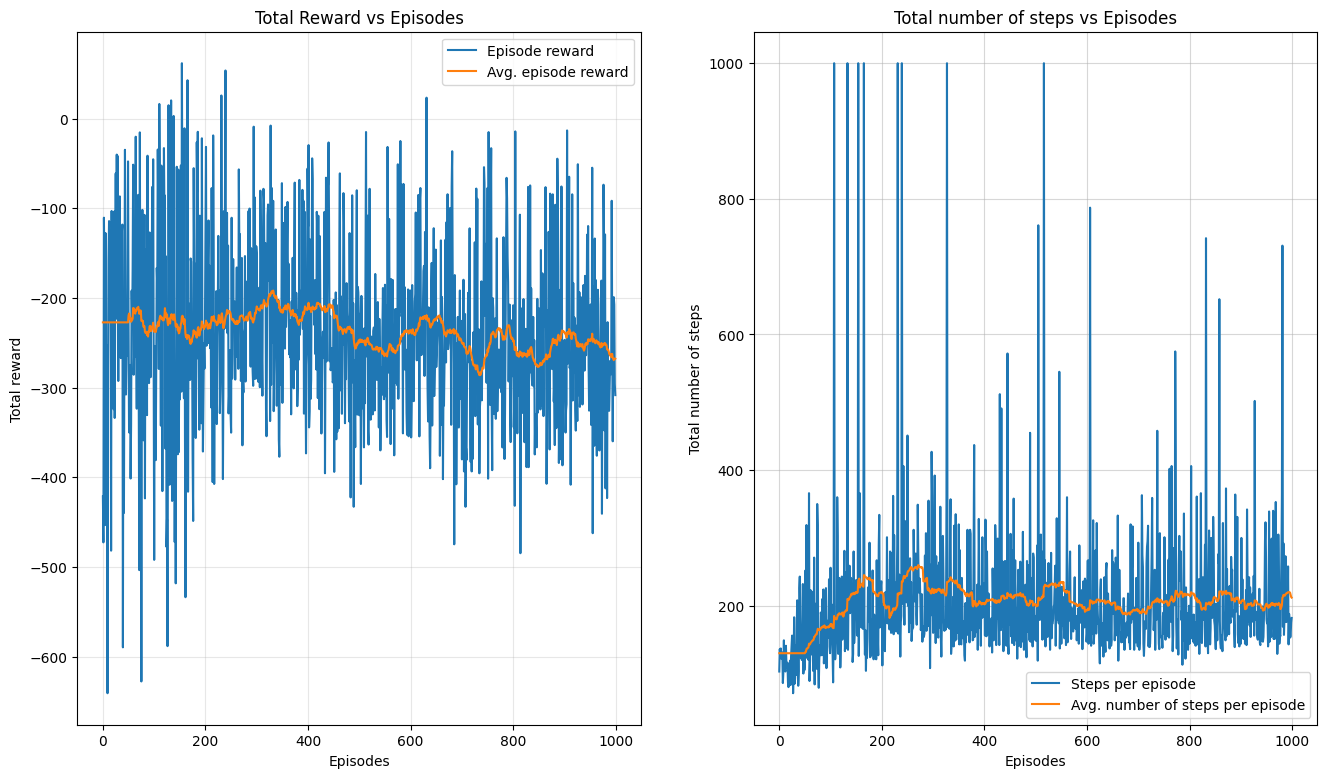

In [34]:
# Plot Rewards and steps
running_avg_window = 50
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

num_episodes = 1000
ax[0].plot(range(num_episodes), episode_rewards, label='Episode reward')
ax[0].plot(range(num_episodes), running_average(
    episode_rewards, running_avg_window), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(range(num_episodes), episode_steps, label='Steps per episode')
ax[1].plot(range(num_episodes), running_average(
    episode_steps, running_avg_window), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.5)

# plt.savefig('figures/output_ppo.png', dpi=300)
plt.show()